# Imbalanced Data + Multiclass Classification


**In this webinar:**

1. Imbalanced Data
    - Why is it a problem?
    - How do we deal with it?
        - Upsampling
        - Downsampling
        - Something in between...? (+ SMOTE)
2. Multiclass Classification
    - What is it?
    - Implementation
    - Evaluating models with multiclass classification

**Objectives**:

- Explain the implications of using imbalanced data
- Distinguish between upsampling and downsampling
- Apply ML models to a multiclass classification problem

In [1]:
# Imports
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Let's import our spam data!
emails = pd.read_csv('spam.csv', encoding = "ISO-8859-1")

# Clean up the data a little
emails = emails[['v1', 'v2']]
emails = emails.rename(columns={"v1": "spam", "v2": "email"})

emails.head()

,spam,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Imbalanced Data

### 1.1 Why is this an issue in machine learning?
Imabalanced data occurs when we have a dataset that has an uneven representation of our classes in our dataset. Let's have a look at the occurrences of ham/spam in our dataset:

In [3]:
emails['spam'].value_counts()

ham     4825
spam     747
Name: spam, dtype: int64

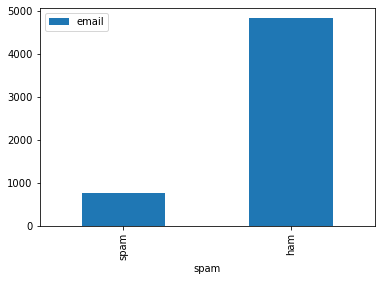

In [4]:
# Let's visualise this:

ham_or_spam = emails[['spam', 'email']].groupby('spam').count()

ham_or_spam.sort_values('spam', ascending=False).plot(kind='bar')
plt.show()

We can clearly see that we have many more occurrences of 'ham' (real emails) than spam. While this might be a good representation of the frequency of occurrence of these in real life, it poses an issue to models trying to make predictions:

- Bias in model prediction
- Misleading evaluation metrics

### 1.2 How do we deal with imbalanced data?


#### 1.2.1 Upsampling

One method of balancing data is upsampling. Upsampling takes our minority class and 'creates' new records by resampling randomly from the data we have existing in that class, until we reach an equal number of records as the majority class. 

![](https://miro.medium.com/v2/resize:fit:670/1*Nvqtr27enOmIFktPYnq_Yg.png)


This process essentially duplicates existing records from the minority class in order to upsample. This in itself can pose some issues:

- Overfitting
- Redundant information
- Amplifying noise
- Computational costs...?

In [5]:
# Upsampling
spam = emails[emails['spam']=='spam']
not_spam = emails[emails['spam']=='ham']

spam_upsampled = resample(spam,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(not_spam), # match number in majority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([spam_upsampled, not_spam])

# Check new class counts
upsampled['spam'].value_counts()

spam    4825
ham     4825
Name: spam, dtype: int64

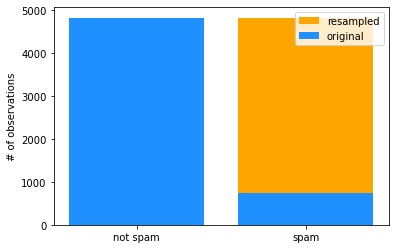

In [30]:
orig_heights = [len(emails[emails['spam']=='ham']),len(emails[emails['spam']=='spam'])]
upsampled_heights = [len(upsampled[upsampled['spam']=='ham']),len(upsampled[upsampled['spam']=='spam'])]

# Get all possible labels
labels = upsampled['spam'].unique()
plt.bar(labels,upsampled_heights,color='orange')
plt.bar(labels,orig_heights,color='dodgerblue')
plt.xticks(labels,['not spam','spam'])
plt.ylabel("# of observations")
plt.legend(['resampled','original'])
plt.show()

*(**Note**: we are not doing proper NLP on this text data for the sake of time. Make sure to use data cleaning and feature engineering with your own data!)*

In [7]:
# Let's see how our model performs with upsampled data...
# Create a CountVectorizer instance
vectorizer = CountVectorizer()


# Fit and transform the documents, set up X and y
X = vectorizer.fit_transform(upsampled['email'])
y = np.array(upsampled['spam'])


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


# Train our model, make predictions
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_upsamp = lr.predict(X_test)


# Classification report
print(classification_report(y_test, y_pred_upsamp))

              precision    recall  f1-score   support

         ham       1.00      0.99      1.00       963
        spam       0.99      1.00      1.00       967

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



#### 1.2.2 Downsampling

Downsampling is essentially the opposite of upsampling. Instead of increasing the number of records in the minority class, we simply **reduce** the number of records in the **majority** class until we have an equal amount of records as in the minority class. 

![](https://miro.medium.com/v2/resize:fit:872/1*-xq4D-UI6ksqFkSBiaZjdA.png)

This process takes a random sample from our majority class, the size of the minority class. Some potential issues of downsampling are:

- Information loss
- Potential biased sampling
- Increased variability
- Generalisation issues

In [8]:
# Downsampling
not_spam_downsampled = resample(not_spam,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(spam), # match number in minority class
                          random_state=27) # reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([not_spam_downsampled, spam])

# Check new class counts
downsampled['spam'].value_counts()

ham     747
spam    747
Name: spam, dtype: int64

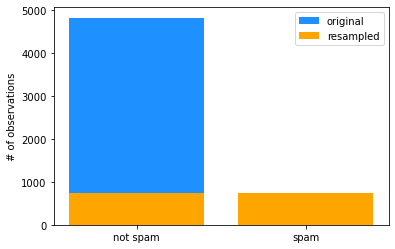

In [31]:
downsampled_heights = [len(downsampled[downsampled['spam']=='ham']),len(downsampled[downsampled['spam']=='spam'])]

# Get all possible labels
labels = downsampled['spam'].unique()
plt.bar(labels,orig_heights,color='dodgerblue')
plt.bar(labels,downsampled_heights,color='orange')
plt.xticks(labels,['not spam','spam'])
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

*(**Note**: we are not doing proper NLP on this text data for the sake of time. Make sure to use data cleaning and feature engineering with your own data!)*

In [32]:
# Let's see how our model performs with downsampled data...
# Create a CountVectorizer instance
vectorizer = CountVectorizer()


# Fit and transform the documents, set up X and y
X = vectorizer.fit_transform(downsampled['email'])
y = np.array(downsampled['spam'])


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


# Train our model, make predictions
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_downsamp = lr.predict(X_test)


# Classification report
print(classification_report(y_test, y_pred_downsamp))

              precision    recall  f1-score   support

         ham       0.93      0.98      0.95       152
        spam       0.98      0.92      0.95       147

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



In [11]:
# Let's now compare with the original data...
# Create a CountVectorizer instance
vectorizer = CountVectorizer() 


# Fit and transform the documents, set up X and y
X = vectorizer.fit_transform(emails['email'])
y = np.array(emails['spam'])


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


# Train our model, make predictions
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_orig = lr.predict(X_test)


# Classification report
print(classification_report(y_test, y_pred_orig))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       957
        spam       1.00      0.89      0.94       158

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.98      0.98      0.98      1115



#### 1.2.3 Something inbetween...?

We can see that there are potential issues for both upsampling and downsampling. What can we do to try and avoid these issues?

One possible way is to get our classes to some sort of middle-point. Upsampling the smaller classes to this midpoint, and downsampling the larger classes to this midpoint. This midpoint could be taken as half the size of the largest class, or maybe a midpoint between the size of your smallest class and the size of your biggest class. There is no one correct answer - it is up to your discretion based on your data.


#### SMOTE

Another method that is used in an attempt to alleviate the issues of plain upsampling/downsampling is SMOTE: Synthetic Minority Over-sampling Technique.

SMOTE is a method that upsamples the minority class, but instead of simply duplicating records from this class, it generates new (synthetic!) examples. It does this by interpolating between a particular data point and its k-nearest neighbours. It uses and combines information from these datapoints to create a new datapoint for our minority class. This is repeated until we reach our desired number of records in the minority class.

![](https://miro.medium.com/v2/resize:fit:850/1*x9KrrnZFwj9Wcw1OnozRLQ.png)

In [29]:
# SMOTE Implementation
from imblearn.over_sampling import SMOTE

X = vectorizer.fit_transform(emails['email'])
y = np.array(emails['spam'])

sm = SMOTE(random_state=27)
X_res, y_res = sm.fit_resample(X, y)

print("Number of 'ham' emails: ", (y_res=='ham').sum())
print("Number of 'spam' emails: ", (y_res=='spam').sum())

Number of 'ham' emails:  4825
Number of 'spam' emails:  4825


Now that we've got our X and y sorted we can try using these with classfication models - we will leave this to you to play around with!

While plain SMOTE upsamples our minority class, there are other variations that can do a combination of upsampling and downsampling (such as SMOTETomek). You can read about some of these here: [link](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/). Feel free to try any of these out on your own data!

## 2. Multiclass Classification

### 2.1 What is it?

Multiclass classification is as the name suggests - classification when we have multiple classes. We've seen with our spam/not spam dataset instances of classification with just two classes (**binary** classification), but most of the time with real-world data we're trying to make classifications with more than two classes! This is referred to as multiclass classification.


### 2.2 Implementation

Let's see how we can use data with multiple classes with firstly a Logistic Regression model, then a Random Forest classifier. 

*(**Note**: we are not doing proper NLP on this text data for the sake of time. Make sure to use data cleaning and feature engineering with your own data!)*

In [103]:
df_reviews = pd.read_csv('amazon_reviews.csv')
df_reviews = df_reviews.drop(columns = 'Unnamed: 0').dropna()

df_reviews.head()

,overall,reviewText
0,4,kids like story BUT while i really wanted a bo...
1,4,Bought this used and it came in great conditio...
2,5,Every story and book about Corduroy is Fantast...
3,5,I purchased this book for my first grade class...
4,5,Having spent numerous years in an elementary s...


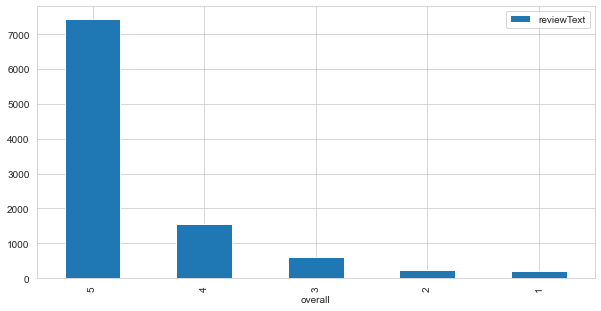

In [104]:
# Let's look at the distribution of ratings in our data

ratings = df_reviews[['overall', 'reviewText']].groupby('overall').count()

sum_rating.sort_values('overall', ascending = False).plot(kind = 'bar')
plt.show()

In [105]:
# Create a CountVectorizer instance
vectorizer = CountVectorizer()


# Fit and transform the documents, set up X and y
X = vectorizer.fit_transform(df_reviews['reviewText'])
y = np.array(df_reviews['overall'])


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)


# Train our Logistic Regression model, make predictions
lr = LogisticRegression(multi_class='ovr')
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


# Train our Random Forest model, make predictions
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

Notice how for the Random Forest classifier, we didn't specify that we were using a dataset with multiple classes. **Scikit-learn's classifiers are actually all equipped to automatically detect and handle multiclass situations**, without you having to do anything extra in your code! If you're curious to read more about multiclass classfications strategies, check out [this page](https://scikit-learn.org/stable/modules/multiclass.html) on the Scikit-learn site about this.

### 2.3 Evaluating models using multiclass classification

In [106]:
#logreg

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           1       0.54      0.16      0.24        45
           2       0.62      0.09      0.16        55
           3       0.32      0.26      0.29       109
           4       0.39      0.25      0.31       299
           5       0.82      0.93      0.87      1492

    accuracy                           0.75      2000
   macro avg       0.54      0.34      0.37      2000
weighted avg       0.72      0.75      0.72      2000



In [107]:
#randfor

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       1.00      0.04      0.09        45
           2       0.75      0.05      0.10        55
           3       0.56      0.08      0.14       109
           4       0.53      0.06      0.10       299
           5       0.76      0.99      0.86      1492

    accuracy                           0.76      2000
   macro avg       0.72      0.25      0.26      2000
weighted avg       0.72      0.76      0.67      2000



We can compare the results from our two classification reports - we see some similar results across the prediction of the class '5'. Both models seem to predict these pretty well, which makes sense given the distributions. Looking at the F1 score, the Logistic Regression model actually does a bit better than the Random Forest model! But, this does not mean that either model cannot be improved - there are so many things we can look into to improve their performance - balancing the data, cleaning/engineering our data (NLP), feature selection methods, tuning some hyperparameters, etc...